# Проект e-commerce: 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.  



## Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

# Загрузим данные

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from calendar import monthrange
from pandasql import sqldf

In [2]:
df1 = pd.read_csv('/home/borislav/Загрузки/olist_customers_dataset.csv')

In [3]:
df1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df2 = pd.read_csv('/home/borislav/Загрузки/olist_orders_dataset.csv')


In [5]:
df2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
df3 = pd.read_csv('/home/borislav/Загрузки/olist_order_items_dataset.csv')


In [7]:
df3.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Объединим их в единый датафрейм , с которым потом будем работать

In [8]:
df = df1.merge(df2, how = 'inner', on = 'customer_id')
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00


In [9]:
df = df.merge(df3, how = 'left', on = 'order_id')


# Обработка данных

In [10]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [11]:
#Посмотрим на типы данных
df.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
dtype: object

In [12]:
#Приведем даты к нужному типу 
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

In [13]:
#Посмотрим число пропусков в колонке
df.isna().mean()


customer_id                      0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_id                         0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001419
order_delivered_carrier_date     0.017351
order_delivered_customer_date    0.028468
order_estimated_delivery_date    0.000000
order_item_id                    0.006833
product_id                       0.006833
seller_id                        0.006833
shipping_limit_date              0.006833
price                            0.006833
freight_value                    0.006833
dtype: float64

# Задание 1

Сколько у нас пользователей, которые совершили покупку только один раз?  


Посмотрим на пользователей, у которых пустые заказы

In [14]:
task1 = df.copy()

In [15]:
task1[task1.product_id.isna() == True]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
50,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaN,NaT,2018-04-09,NaN,NaN,NaN,NaN,NaN,NaN
330,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaN,NaT,2017-03-10,NaN,NaN,NaN,NaN,NaN,NaN
422,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaN,NaT,2018-06-05,NaN,NaN,NaN,NaN,NaN,NaN
432,536f46cc0f2f2b1e40d056f7998f0254,340152332a04149987a705602615f0d0,87030,maringa,PR,cb4a79c1e6c9ae44302861e7602cc449,unavailable,2017-12-06 15:46:07,2017-12-06 15:57:29,NaN,NaT,2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN
627,8118922685d2e2c0205f060be4f2579c,d0e87d00021530383c16452a39a393ba,45810,porto seguro,BA,af264f3527e94e431f0dcd56cd6b406d,unavailable,2017-07-12 14:49:11,2017-07-12 15:04:10,NaN,NaT,2017-08-11,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112085,7353b0fb8e8d9675e3a704c60ca44ebe,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP,2f634e2cebf8c0283e7ef0989f77d217,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaT,2017-10-27,NaN,NaN,NaN,NaN,NaN,NaN
112143,5effe9491d0f5a1c12ee4a384ec09bdf,e9429d622d9e764ca60ba01bc252b0a8,8690,suzano,SP,2b0edc4c59d83dcef85466718c36a317,unavailable,2017-09-29 19:17:10,2017-09-29 20:00:07,NaN,NaT,2017-10-17,NaN,NaN,NaN,NaN,NaN,NaN
112412,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2018-08-20 09:03:23,NaT,NaN,NaT,2018-09-03,NaN,NaN,NaN,NaN,NaN,NaN
112517,1761db2f0d235bbfa1c281093198af0c,21c2c79d24e2d8e3496aabb1f65d85c6,20270,rio de janeiro,RJ,8b08f0e729f58529ed03e763270f78d5,unavailable,2017-08-24 21:02:47,2017-08-24 21:15:36,NaN,NaT,2017-09-27,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Заменим пропуски в колонке подтверждения оплаты 
task1['order_approved_at'] = task1.order_approved_at.fillna(0)

In [17]:
task1[task1['order_approved_at'] == 0].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

Мы видим, что у нас есть заказы, которые отменяют(возможно из-за цены, качества) или они недоступны. Так же в данных есть заказы, в которых не указана дата отправки(мы им присвоили 0)-они получили статус доставлен, создан, отменен. Я буду считать покупателями всех, у кого подтвержденная оплата заказа, так-как они тоже являются нашими потенциальными клиентами. К тому же, пропуски составляют маленький процент в данных. 

In [18]:
task1 = task1[task1['order_approved_at'] != 0].groupby('customer_unique_id')['order_approved_at'].agg('count').reset_index()

In [19]:
len(task1[task1['order_approved_at'] == 1])

84097

### Итого у нас **84097** пользователей сделали только одну покупку

# Задание 2

2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [20]:
task2 = df.copy()

In [21]:
#Отбираем недоставленные и отмененные заказы 
task2 = task2[(task2['order_status']== 'canceled') | (task2['order_status'] == 'unavailable')]

In [22]:
#Переводим в дату(месяц, год) для группировки
task2['order_approved_at'] = pd.to_datetime(task2['order_approved_at'])

In [23]:
task2['order_approved_at'] = task2['order_approved_at'].dt.strftime('%m %Y')

In [24]:
#Считаем количество заявок
task2 = task2.groupby(['order_approved_at','order_status'])['customer_unique_id'].agg('count').reset_index()

In [25]:
task2.head(10)

,order_approved_at,order_status,customer_unique_id
0,01 2017,canceled,2
1,01 2017,unavailable,8
2,01 2018,canceled,34
3,01 2018,unavailable,47
4,02 2017,canceled,15
5,02 2017,unavailable,47
6,02 2018,canceled,76
7,02 2018,unavailable,31
8,03 2017,canceled,32
9,03 2017,unavailable,32


In [26]:
task2.order_approved_at = pd.to_datetime(task2['order_approved_at'])

In [27]:
# Посчитаем сколько в среднем заявок теряются из-за отмены заказа. Для этого общее число отмененных заявок разделим на число уникальных месяцев
mean_canceled = task2[task2['order_status'] == 'canceled']['customer_unique_id'].sum() / len(task2['order_approved_at'].unique())

In [28]:
mean_canceled

26.904761904761905

In [29]:
mean_unavailable = task2[task2['order_status'] == 'unavailable']['customer_unique_id'].sum() / len(task2['order_approved_at'].unique())

In [30]:
mean_unavailable

29.047619047619047

Получается, за все время в среднем в месяц не доставляется **26.91** заказов из-за отмены, а так же **29.05** из-за отсутствия. 

# Задание 3

 По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [31]:
task3 = df.copy()

In [32]:
task3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [33]:
# Оставляем день недели
task3['order_approved_at'] = task3['order_approved_at'].dt.strftime('%A')

In [34]:
# считаем заказы
task3 = task3.groupby(['order_item_id', 'order_approved_at'])['customer_unique_id'].agg('count').reset_index()

In [35]:
# Получаем дни, когда число заказов было максимальным. Для этого используем внутреннее соединение двух датафреймов по ключу и числу заказов. 
# В первом - максимальное числов заказов для ключа, во втором- даты, которые соответсвуют числу заказов по ключу
result3 = task3.groupby(['order_item_id'])['customer_unique_id'].max().reset_index().merge(task3, how = 'inner', on = ['order_item_id','customer_unique_id'])

In [36]:
result3.groupby(['order_item_id','customer_unique_id'])['order_approved_at'].agg(lambda order_approved_at: ', '.join(order_approved_at)).reset_index()

,order_item_id,customer_unique_id,order_approved_at
0,1.0,19031,Tuesday
1,2.0,1951,Tuesday
2,3.0,463,Tuesday
3,4.0,180,Tuesday
4,5.0,90,Tuesday
5,6.0,56,Thursday
6,7.0,10,"Saturday, Thursday, Tuesday"
7,8.0,8,Friday
8,9.0,7,Friday
9,10.0,6,Friday


Получен датафрейм для каждого товара, в котором показаны максимальные дни продаж

# Задание 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [37]:
task4 = df.copy()
# Заменим пропуски в колонке подтверждения оплаты 
task4['order_approved_at'] = task4.order_approved_at.fillna(0)
# Отберем данные , где была подтверждена оплата
task4 = task4[task4['order_approved_at'] != 0]

In [38]:
task4['order_approved_at'] = pd.to_datetime(task4.order_approved_at)

In [39]:
# Создадим колонку , которая будет считать неделю в месяце
task4['month'] = task4['order_approved_at'].dt.month
task4['year'] = task4['order_approved_at'].dt.year


In [40]:

task4.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'month',
       'year'],
      dtype='object')

In [41]:
# удалим ненужные
task4 = task4.drop(columns= ['customer_zip_code_prefix',
       'customer_city', 'customer_state','order_purchase_timestamp','customer_id','order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id','shipping_limit_date', 'price', 'freight_value'])

In [42]:
# посчитаем количество дней в каждом месяце
f = lambda row: monthrange(row['year'], row['month'])[1]
task4['days_in_month'] = task4.loc[:,['year','month']].apply(f, axis = 1)

In [43]:
# сгруппируем колонки по пользователю, месяцу, году и посчитаем заказы
task4 = task4.groupby(['customer_unique_id','month', 'year', 'days_in_month']).count().rename(columns = {'order_id':'orders'})

In [44]:
task4 = task4.drop(columns= ['order_status', 'order_approved_at', 'product_id',
       'seller_id']).reset_index()

In [45]:
# посчитаем среднее число недель в месяце
task4['weeks_in_month'] = round(task4['days_in_month'] / 7,2)

In [46]:
# считаем среднее заказов
task4['mean_orders_per_week'] = task4['orders'] / task4['weeks_in_month']

In [47]:
task4.sort_values(['year', 'month', 'mean_orders_per_week'], ascending=False)

,customer_unique_id,month,year,days_in_month,orders,weeks_in_month,mean_orders_per_week
97570,ff22e30958c13ffe219db7d711e8f564,9,2018,30,1,4.29,0.233100
76689,c8460e4251689ba205045f3ea17884a1,8,2018,31,24,4.43,5.417607
76954,c8ed31310fc440a3f8031b177f9842c3,8,2018,31,10,4.43,2.257336
3353,08a374bca4063116d5530a7b04ecaf3f,8,2018,31,7,4.43,1.580135
73379,bf869f6a89c8ba217f47e22359f884f2,8,2018,31,7,4.43,1.580135
...,...,...,...,...,...,...,...
97009,fdaa290acb9eeacb66fa7f979baa6803,10,2016,31,1,4.43,0.225734
97603,ff39ae410be7f9b3a2457c546c6f67de,10,2016,31,1,4.43,0.225734
97722,ff822e5e1322cef6c211ad8a0591999e,10,2016,31,1,4.43,0.225734
97725,ff8557b296729eaa30f078d974c86812,10,2016,31,1,4.43,0.225734


# Задание 5

Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [48]:
task5 = df[['customer_unique_id', 'order_approved_at']].copy().dropna()

In [49]:
task5['OrderPeriod'] = pd.to_datetime(task5.order_approved_at).apply(lambda x: x.strftime('%Y-%m')).copy()
task5.dtypes

customer_unique_id            object
order_approved_at     datetime64[ns]
OrderPeriod                   object
dtype: object

Возьмем период за 2017 год

In [50]:
task5 = task5[(task5['order_approved_at'] > '2016-12-31') & (task5['order_approved_at'] < '2018-01-01') ]

In [51]:
first_date = task5.groupby('customer_unique_id')['order_approved_at'].agg('min').dt.strftime('%Y-%m').reset_index().rename(columns = {'order_approved_at':'JoinMonth'})

In [52]:
orders_merged = task5.merge(first_date, how = 'inner', on ='customer_unique_id')


In [53]:
orders_merged['TotalOrders'] = 0

In [54]:
orders_merged

,customer_unique_id,order_approved_at,OrderPeriod,JoinMonth,TotalOrders
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,2017-05,2017-05,0
1,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:25:11,2017-09,2017-09,0
2,4c93744516667ad3b8f1fb645a3116a4,2017-10-15 13:05:29,2017-10,2017-09,0
3,57b2a98a409812fe9618067b6b8ebe4f,2017-11-16 19:55:41,2017-11,2017-11,0
4,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 18:01:20,2017-11,2017-11,0
...,...,...,...,...,...
51248,277490f0d435b602fe4475d4b89e9181,2017-05-25 02:50:25,2017-05,2017-05,0
51249,e7f8760e2bbd2f1986bebd99596c088e,2017-03-15 21:04:08,2017-03,2017-03,0
51250,4b5820135d360a45552b5163835b1d89,2017-12-18 00:17:27,2017-12,2017-12,0
51251,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:31:20,2017-11,2017-11,0


In [55]:
grouped = orders_merged.groupby(['JoinMonth', 'OrderPeriod'])
# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'customer_unique_id': pd.Series.nunique,
 'TotalOrders': pd.Series.count, })
# переименуем некоторые столбцы для большей наглядности
cohorts.rename(columns={'customer_unique_id': 'TotalUsers',
 'TotalOrders': 'TotalOrders'}, inplace=True)
cohorts.head()


TotalUsers  TotalOrders
JoinMonth OrderPeriod                         
2017-01   2017-01             727          916
          2017-02               4            4
          2017-03               2            2
          2017-04               1            1
          2017-05               3            3

In [56]:
def cohort_period(df):
 df['CohortPeriod'] = np.arange(len(df)) + 1 # отсчет с 1
 return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  CohortPeriod
JoinMonth OrderPeriod                                       
2017-01   2017-01             727          916             1
          2017-02               4            4             2
          2017-03               2            2             3
          2017-04               1            1             4
          2017-05               3            3             5

In [57]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortPeriod','JoinMonth'], inplace=True)
# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=1).first()
cohort_group_size.head()

JoinMonth
2017-01     727
2017-02    1736
2017-03    2643
2017-04    2324
2017-05    3592
Name: TotalUsers, dtype: int64

In [58]:
cohort_group_size

JoinMonth
2017-01     727
2017-02    1736
2017-03    2643
2017-04    2324
2017-05    3592
2017-06    3148
2017-07    3844
2017-08    4204
2017-09    4149
2017-10    4433
2017-11    7164
2017-12    5638
Name: TotalUsers, dtype: int64

In [59]:
cohorts['TotalUsers'].unstack(0)

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11
JoinMonth,,,,,,,,,,,
2017-01,727.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,2.0,2.0
2017-02,1736.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0
2017-03,2643.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN
2017-04,2324.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN
2017-05,3592.0,19.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN
2017-06,3148.0,15.0,11.0,13.0,8.0,11.0,12.0,NaN,NaN,NaN,NaN
2017-07,3844.0,20.0,13.0,8.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-08,4204.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4149.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=0)



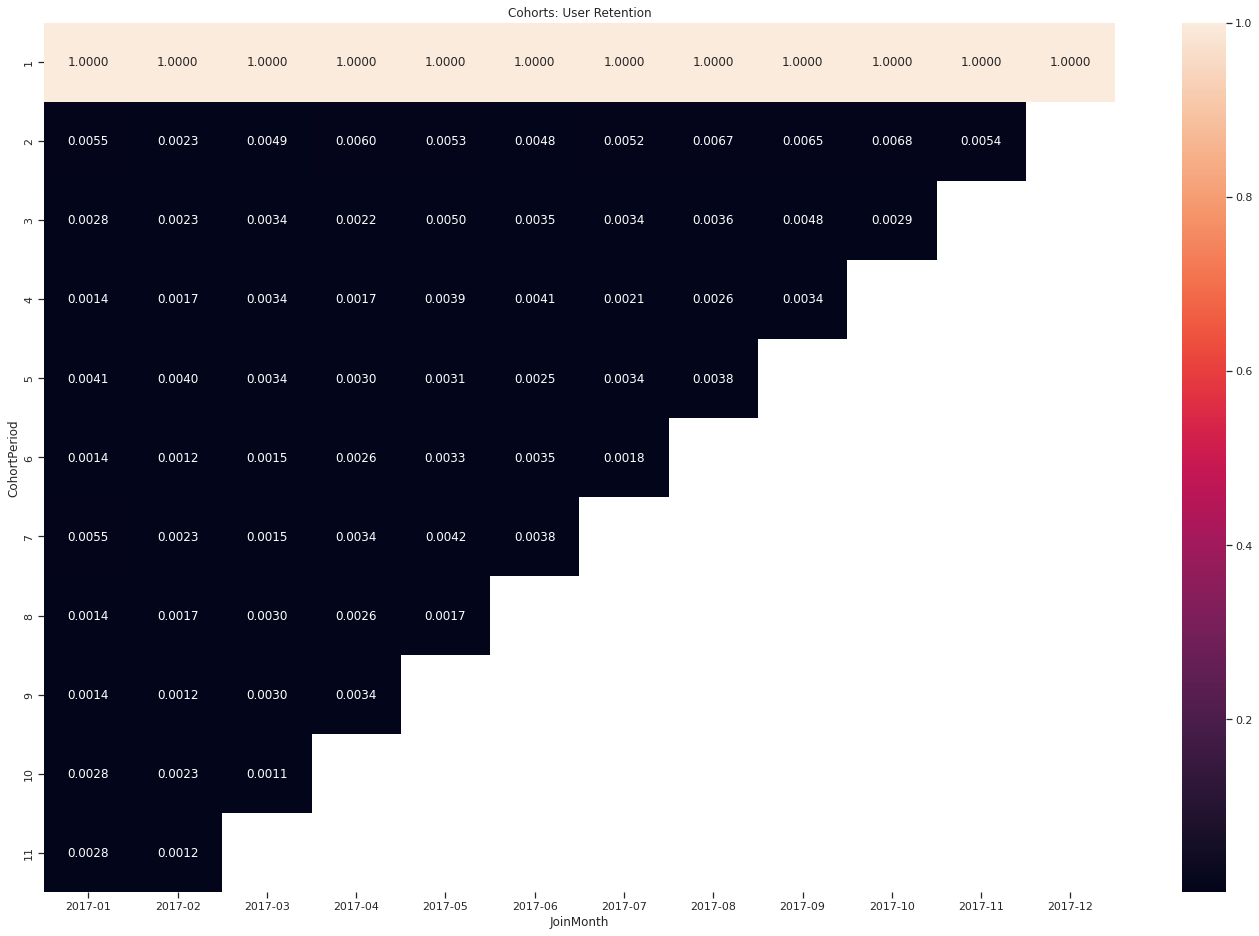

In [61]:
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.4f');

In [62]:
user_retention.style.highlight_max(axis='index')

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11
JoinMonth,,,,,,,,,,,
2017-01,1.000000,0.005502,0.002751,0.001376,0.004127,0.001376,0.005502,0.001376,0.001376,0.002751,0.002751
2017-02,1.000000,0.002304,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152
2017-03,1.000000,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,nan
2017-04,1.000000,0.006024,0.002151,0.001721,0.003012,0.002582,0.003442,0.002582,0.003442,nan,nan
2017-05,1.000000,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,nan,nan,nan
2017-06,1.000000,0.004765,0.003494,0.004130,0.002541,0.003494,0.003812,nan,nan,nan,nan
2017-07,1.000000,0.005203,0.003382,0.002081,0.003382,0.001821,nan,nan,nan,nan,nan
2017-08,1.000000,0.006660,0.003568,0.002617,0.003806,nan,nan,nan,nan,nan,nan
2017-09,1.000000,0.006508,0.004820,0.003374,nan,nan,nan,nan,nan,nan,nan


Когорта пользователей, совершивших первую покупку 2017-05 показала самый высокий ретеншн на 3 месяц

# Задание 6

In [63]:
task6 = df.copy()
#смотрим пропуски
task6.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
dtype: int64

In [64]:
task6.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [65]:
# удаляем пропуски из колонок для анализа аудитории
task6.dropna(subset= ['order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value'], inplace= True)

task6.drop(columns = ['customer_id','customer_zip_code_prefix',
       'customer_city', 'customer_state','order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date'], inplace= True)       


#### Произведем RFM сегментацию пользователей. R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

#### R


In [66]:
# Последний день покупок будет текущим днем(настоящее время) в анализе
task6['order_purchase_timestamp'] = pd.to_datetime(task6['order_purchase_timestamp'])
last_day_analysis = task6['order_purchase_timestamp'].max()


In [67]:
# Дата последней покупки каждого пользователя
last_day_purchase = task6.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index().copy()
last_day_purchase['days_long'] = last_day_analysis - last_day_purchase['order_purchase_timestamp']

In [68]:
last_day_purchase

,customer_unique_id,order_purchase_timestamp,days_long
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115 days 22:10:30
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118 days 21:55:30
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541 days 12:01:54
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325 days 12:37:16
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292 days 13:21:15
...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,451 days 12:06:21
95416,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,266 days 12:59:01
95417,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,572 days 17:17:41
95418,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,123 days 17:49:16


#### F

In [69]:
# Общее число заказов
orders = task6.groupby('customer_unique_id')['order_id'].count().reset_index().copy()

#### M

#

In [70]:
# Общая сумма покупок за все время
sum_orders = task6.groupby('customer_unique_id')['price'].sum().reset_index().copy()

In [71]:
task6 = last_day_purchase.merge(orders, on = 'customer_unique_id')

In [72]:
task6 = task6.merge(sum_orders, on = 'customer_unique_id')

In [73]:
task6.rename(columns={'order_id':'number_of_orders',
                       'price' : 'total_amount'     }, inplace=True)

#### Сделаем итоговый датафрейм с RFM сегментацией 

In [74]:
labels_3 = [1,2,3]
task6['R'] = pd.qcut(task6['days_long'], q = [0, .33, .66, 1] , labels= labels_3[::-1])
task6['F'] = pd.qcut(task6['number_of_orders'], q  = [0, .95, .99, 1], labels = labels_3) # здесь разбиваем на данные пропорции, так-как большинство людей делает не более 1 заказа
task6['M'] = pd.qcut(task6['total_amount'], q = [0, .33, .66, 1], labels = labels_3)


Мы сделали датафрейм, распределив на 3 категории с указанными квантилями (переменная q).  F категории мы указали другие квантили, потому что большинство людей соверашали 1 покупку, тогда как люди имеющие 20+ покупок для нас являются аномалией. У них значение F = 3


In [75]:
task6 = task6.astype({'R' :'str', 'F' : 'str', 'M' : 'str'})
task6['RFM'] = task6['R'] + task6['F'] + task6['M']

In [76]:
task6

,customer_unique_id,order_purchase_timestamp,days_long,number_of_orders,total_amount,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115 days 22:10:30,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118 days 21:55:30,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541 days 12:01:54,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325 days 12:37:16,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292 days 13:21:15,1,180.00,1,1,3,113
...,...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,451 days 12:06:21,2,1570.00,1,1,3,113
95416,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,266 days 12:59:01,1,64.89,2,1,2,212
95417,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,572 days 17:17:41,1,89.90,1,1,2,112
95418,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,123 days 17:49:16,1,115.00,3,1,2,312


 Самые выгодные покупатели R, F, M - для нас начинаются с 3 (недавно покупали, больше покупали, самый большой чек) , а 1 (давно покупали, меньше брали, маленький чек), 2 - промежуточный вариант

<AxesSubplot:xlabel='count', ylabel='RFM'>

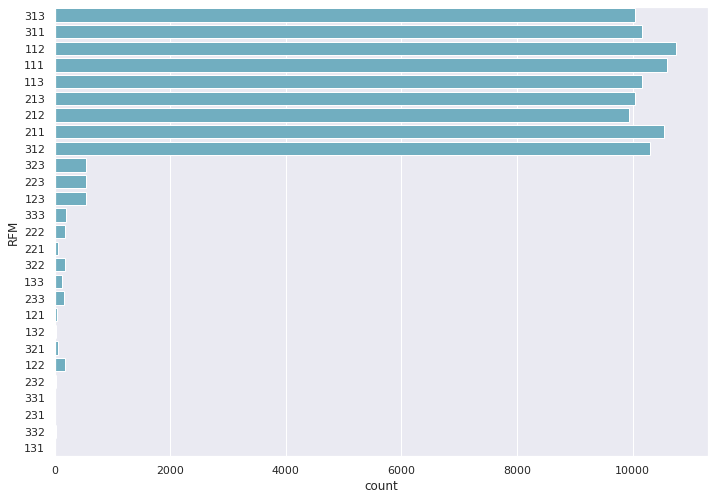

In [77]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y= "RFM", data= task6, color="c")

Здесь показано распределение сегментов по количеству